## MSDS 7331 Data Mining: Regression & SVM

***  

Team: Andrew Abbott, Vivek Bejugama, Patrick McDevitt, Preeti Swaminathan



***
	
We are using online news popularity dataset from UCI machine learning repository. The dataset is a collection of 61 heterogeneous set of features of approximately 40,000 articles published by Mashable (www.mashable.com) - the features are not the articles, but features extracted from the article, such as word counts, title word counts, keyword associations.  The data represents a two year period of published articles, ending in January 2015.  

We intend to mine this data to understand what parameters can influence an article to be shared on social media more than others.  The goal is to predict the number of shares in social networks (popularity).  

The business use of this data set / data mining project is ultimately to establish relationships that enable to predict how many social media shares an article published on _www.mashable.com_ is likley to generate - with the idea that a more socially shared article has higher business value - increasing traffic to the site, and consequently, potential for higher earnings revenue associated to the increased web traffic. The user of this model is both the publishers for _mashable.com_ for article selection, and also for authors, attempting to create content that has higher value on sites like _mashable.com_.  

Measures for a successful outcome from a predictive model for this study will be based on overall accuracy metrics (e.g., confusion matrix), as well as AUC type metrics. A baseline (non-predictive, random) scoring will establish a baseline for these metrics, and then the predictive model can be assessed against a random model for measurement of improvement, i.e., value of the model.  

The data is located at https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity  

***  
__Citation Request__ :  
***  
K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.  
***  


- The data set has features in these 6 broad categories :  
_(ref - see citation reference at beginning of this document)_  
    - Words  
        - Number of words of the title/content  
        - Average word length  
        - Rate of unique/non-stop words of contents
    - Links
        - Number of links  
        - Number of links to other articles in Mashable  
    - Digital Media  
        - Number of images/videos  
    -Time  
        - Day of the week/weekend  
    - Keywords  
        - Number of keywords  
        - Worst/best/average keywords (#shares)  
        - Article category  
    - NLP  
        - Closeness to five LDA topics  
        - Title/Text polarity/subjectivity  
        - Rate and polarity of positive/negative words  
        - Absolute subjectivity/polarity level  
     



In [31]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  - Revisions

# ...  2017.09.28
# ...  - general rewrite of data cleaning / create input data set for models
# ...  - added first set of SVM models
# ...
# ...  2017.10.01
# ...  - added additional metrics (precision, recall, F1) to SVM model outputs
# ...  - updated KDE plots to top weighted support vectors from linear SMV model
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=



### __Grading Rubric__  

#### __Create Models (50)__    

* Create a logistic regression model and a support vector machine model for the classification task involved with your dataset.  
* Assess how well each model performs (use 80/20 training/testing split for your data).  
* Adjust parameters of the models to make them more accurate.  
* If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines.  
* For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.   


#### __Model Advantages (10)__  

* Discuss the advantages of each model for each classification task.  
* Does one type of model offer superior performance over another in terms of prediction accuracy?  
* In terms of training time or efficiency?  
* Explain in detail.  

#### __Interpret Feature Importance (30)__  

* Use the weights from logistic regression to interpret the importance of different features for the classification task.  
* Explain your interpretation in detail.  
* Why do you think some variables are more important?  


#### __Interpret Support Vectors (10)__  

* Look at the chosen support vectors for the classification task.  
* Do these provide any insight into the data? Explain.  
* If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model — then analyze the support vectors from the subsampled dataset.  



In [32]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#...  Import Required Packages
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore',DeprecationWarning)

import seaborn as sns


import time


In [33]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  Import Data from .csv file
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... change directory as needed to point to local data file 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

data_dir = '../data/'
data_file = 'OnlineNewsPopularity.csv'

file_2_read = data_dir + data_file

df = pd.read_csv(file_2_read)  


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  Strip leading spaces and store all the column names to a list
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df.columns = df.columns.str.strip()

col_names = df.columns.values.tolist()




In [34]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  From EDA project, these are the features that we called important 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

imp_features = ['n_tokens_title',
 'n_tokens_content',
 'num_hrefs',
 'num_imgs',
 'num_videos',
 'num_keywords',
 'kw_avg_avg',
 'self_reference_avg_sharess',
 'LDA_00',
 'LDA_01',
 'LDA_02',
 'global_rate_positive_words',
 'global_rate_negative_words',
 'avg_negative_polarity',
 'title_sentiment_polarity',
 'abs_title_subjectivity']

df_imp = df[imp_features]

# ...  add 'popular' binary column 

popular_binary = np.where(df['shares'] > 1400, True, False)
df_imp.insert(loc = 0, column = 'popular', value = popular_binary)

# ...  store as reduced dataframe 

df_imp.info()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  write these to .csv file and we can recall later
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

data_dir = '../data/'
data_file = 'mashable_imp_features_from_eda.csv'

file_2_write = data_dir + data_file

df_imp.to_csv(file_2_write, index = False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 17 columns):
popular                       39644 non-null bool
n_tokens_title                39644 non-null float64
n_tokens_content              39644 non-null float64
num_hrefs                     39644 non-null float64
num_imgs                      39644 non-null float64
num_videos                    39644 non-null float64
num_keywords                  39644 non-null float64
kw_avg_avg                    39644 non-null float64
self_reference_avg_sharess    39644 non-null float64
LDA_00                        39644 non-null float64
LDA_01                        39644 non-null float64
LDA_02                        39644 non-null float64
global_rate_positive_words    39644 non-null float64
global_rate_negative_words    39644 non-null float64
avg_negative_polarity         39644 non-null float64
title_sentiment_polarity      39644 non-null float64
abs_title_subjectivity        39644 non-null f

In [35]:
# Summary of attributes
df.info()

df.describe().T


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... drop a few columns just based on inspection
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ...  these 2 columns are all zeros except for 1 data point

del df['n_non_stop_words']
del df['n_non_stop_unique_tokens']
del df['n_unique_tokens']


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... make some decisions about what to do with these ...
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ... average_token_length has a high number of zeros .. is this OK or do they want to be imputed ?
# ... average_negative_polarity has population of zeros ... OK or impute ?
# ... average postivie polarity ... same as above
# ... global_rate_postive_words ... same as above
# ... global_subjectivity ... same as above
# ... kw_min_avg ... same as above
# ... kw_min_min ... weird data ... maybe just delete ?



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
url                              39644 non-null object
timedelta                        39644 non-null float64
n_tokens_title                   39644 non-null float64
n_tokens_content                 39644 non-null float64
n_unique_tokens                  39644 non-null float64
n_non_stop_words                 39644 non-null float64
n_non_stop_unique_tokens         39644 non-null float64
num_hrefs                        39644 non-null float64
num_self_hrefs                   39644 non-null float64
num_imgs                         39644 non-null float64
num_videos                       39644 non-null float64
average_token_length             39644 non-null float64
num_keywords                     39644 non-null float64
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null floa

In [36]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  convert the data type to Integer
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

to_int = ['timedelta','n_tokens_title', 'n_tokens_content',
          'num_hrefs','num_self_hrefs', 'num_imgs', 'num_videos', 'num_keywords','shares']

df[to_int] = df[to_int ].astype(np.int64)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  check for duplicates
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df[df.duplicated()]


,url,timedelta,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares


#### Create new features from existing data set  

- Based on inspection of the data set, we ideitified several opportunities to create some useful features from the original data set.

- The first data field, _url_, is the url address of the mashable published article, which contains in the link the year, month, day that the article was published and also the article title. We will use a string splitting function to parse the information in the url address to create the additional data columns : _year_, _month_, _day_, and _title_. Further, we can then combine the parsed year, month, day into a _published_date_ column. Although the original data set does contain the field _timedelta_ which provdes essentially a timeline of article publication dates, it does not contain the actual date of publication. We consider that having the actual date may prove useful to provide context or linkage with external data sources. We are not, at this time, linking in any additional external data sources, but that may be an opportunity with future work. In addition, we consider to storethe _title_ as a distinct data column, but we are not performing any analysis on that field at this time. We consider that the article title is an opportunity for text mining in the classification problem to be evaluated also with future work.  

- The data fields : _is_entertainment_, _is_lifestyle_, ... are each boolean indicators of the type of data channel associated to the published article. Since these are mutually exclusive binary indicators, we can combine into one common feature, _data_channel_, to condense the information of those 6 columns into one column. This provides some reduction in complexity of the data set, and also provides opportunity to more easily make comparison plots for the relative popularity of these data channels.  

- Similar to the _data_channel_ column, there is also a set of columns : _is_monday_, _is_tuesday_, ... which are also a set of mutually exclusive binary indicators. Using the same logic as above, we combine those values into a single column _day_of_week_. There is an additional column _is_weekend_ which we retain for now, as that provides opportunity to evaluate if weekend responses are different than weekday responses.  

- And finally, we also created a column to be used as binary popularity measure. Based on the business description of the goal, the goal is to build a model that provides predictive capability of article 'popular' or 'not popular', based on the metric of number of shares > 1400 (popular) or number of shares < 1400 (not popular). The value of 1400 was provided in the business statement, and is also the median value of the number of shares in the experience of this data set. To accomplish that purpose, we create a new column (binary) _popularity_ which is based on the number of shares reported in the _shares_ data column. This can be used in future work, e.g., in classificiation or binary logistic regression analyses to support the business goal.  

- The code to accomplish all of the above is shown here below.  

***  


In [37]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Extract useable elemnts from the string URL
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['http'], df['blank'], df['mash'], df['year'], df['month'], df['day'],df['title'],df['extra'] = df['url'].str.split('\/', 7).str

# ...  delete unneeded columns

del df['http'], df['blank'], df['mash'], df['extra']
del df['url']
del df['title']

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  Derive date column from year-month-day fields
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['year']  = (df['year']).astype(str)
df['month'] = (df['month']).astype(str)
df['day']   = (df['day']).astype(str)
df['publish_date'] = pd.to_datetime(df.year + df.month + df.day, format = "%Y%m%d")

del df['month']
del df['day']

df['year'] = df['year'].astype(int)

del df['publish_date'] ## ... remove for SVM data set ... add back in for timeline plots

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Creating day_of_week categorical variable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['day_of_week'] = 'Mon'

tuesday = df['weekday_is_tuesday'] == 1
df.loc[tuesday, 'day_of_week'] = 'Tue'

wednesday = df['weekday_is_wednesday'] == 1
df.loc[wednesday, 'day_of_week'] = 'Wed'

thursday = df['weekday_is_thursday'] == 1
df.loc[thursday, 'day_of_week'] = 'Thu'

friday = df['weekday_is_friday'] == 1
df.loc[friday, 'day_of_week'] = 'Fri'

saturday = df['weekday_is_saturday'] == 1
df.loc[saturday, 'day_of_week'] = 'Sat'

sunday = df['weekday_is_sunday'] == 1
df.loc[sunday, 'day_of_week'] = 'Sun'

# ...  delete unneeded columns

del df['weekday_is_monday'], df['weekday_is_tuesday'], df['weekday_is_wednesday'], df['weekday_is_thursday']
del df['weekday_is_friday'], df['weekday_is_saturday'], df['weekday_is_sunday']

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... creating data_channel categorical variable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['data_channel'] = np.NaN

condition = df['data_channel_is_lifestyle'] == 1
df.loc[condition, 'data_channel'] = 'Lifestyle'

condition = df['data_channel_is_entertainment'] == 1
df.loc[condition, 'data_channel'] = 'Entertainment'

condition = df['data_channel_is_bus'] == 1
df.loc[condition, 'data_channel'] = 'Business'

condition = df['data_channel_is_socmed'] == 1
df.loc[condition, 'data_channel'] = 'SocMed'

condition = df['data_channel_is_tech'] == 1
df.loc[condition, 'data_channel'] = 'Tech'

condition = df['data_channel_is_world'] == 1
df.loc[condition, 'data_channel'] = 'World'

# ...  delete unneeded columns

del df['data_channel_is_lifestyle'], df['data_channel_is_entertainment'], df['data_channel_is_bus']
del df['data_channel_is_socmed'], df['data_channel_is_tech'], df['data_channel_is_world']



In [38]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  ln() transform right skewed distribution variables (skewness > 1)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for skewness, create new column if conditions met
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for column in numeric_col_names:
    sk = df[column].skew()
    
    if(sk > 1):
        new_col_name = 'ln_' + column
        print (column, sk, new_col_name)
        
        if df_mins[column] > 0:
            df[new_col_name] = np.log(df[column])
            
        elif df_mins[column] == 0:
            df_tmp = df[column] + 1
            df[new_col_name] = np.log(df_tmp)
            
        else:
            print('--> Ln() transform not completed -- skew > 1, but min value < 0 :', column, '!!')
            
            
# ... delete tmp data

del df_tmp
del df_mins
del df_numeric


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  based on inspection, a few of these are just not valid ranges in ln() space
# ...  -- just delete these few back out of the data set
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

del df['ln_is_weekend']

del df['ln_LDA_00']
del df['ln_LDA_01']
del df['ln_LDA_02']
del df['ln_LDA_03']
del df['ln_LDA_04']

# ... not needed for binary analysis ... will use popular indicator

del df['ln_shares'] 


print ('\n-----------------------------------\n')
print ('Number of current columns in dataset :', len(df.columns))


n_tokens_content 2.94542193879 ln_n_tokens_content
num_hrefs 4.0134948282 ln_num_hrefs
num_self_hrefs 5.17275110576 ln_num_self_hrefs
num_imgs 3.94659584465 ln_num_imgs
num_videos 7.0195327863 ln_num_videos
kw_min_min 2.37494728018 ln_kw_min_min
--> Ln() transform not completed -- skew > 1, but min value < 0 : kw_min_min !!
kw_max_min 35.3284337312 ln_kw_max_min
kw_avg_min 31.3061081027 ln_kw_avg_min
--> Ln() transform not completed -- skew > 1, but min value < 0 : kw_avg_min !!
kw_min_max 10.3863716348 ln_kw_min_max
kw_max_avg 16.4116695554 ln_kw_max_avg
kw_avg_avg 5.76017729162 ln_kw_avg_avg
self_reference_min_shares 26.2643641603 ln_self_reference_min_shares
self_reference_max_shares 13.8708490494 ln_self_reference_max_shares
self_reference_avg_sharess 17.9140933777 ln_self_reference_avg_sharess
is_weekend 2.18850033431 ln_is_weekend
LDA_00 1.5674632332 ln_LDA_00
LDA_01 2.08672182342 ln_LDA_01
LDA_02 1.31169490203 ln_LDA_02
LDA_03 1.23871598638 ln_LDA_03
LDA_04 1.17312947598 ln_LDA_

#### Data Selection - First evaluation  

- There are 60 columns in the original data set; we added a few additonal columns based on observed opportunities (e.g., _publication_date_, ...) as explained above. 
    
- From this data set, we did a simple correlation matrix to look for variables that are highly correlated with each other that could be removed with little loss of information.

- With that downselection, we proceeded with additional evaluation of these remaining variables.
    
- we recognize that there is likely significant additional opportunity for modeling improvements with many of the remaining variables, and will look to re-expand the data set to further consider that with future work.  

In [39]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... display highest correlation pairs from corr() matrix 
# ...
# ... https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n = 5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n]

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... list out Top30 correlations
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

n_val = 30

top_30_corr_list = get_top_abs_correlations(df_numeric, n_val)
print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Top Absolute Correlations\n")
print(top_30_corr_list)

icor = 0
drop_column = list()
while (top_30_corr_list[icor] > 0.7):
    drop_column.append(top_30_corr_list[top_30_corr_list == top_30_corr_list[icor]].index[0][0])
    icor += 1

drop_column = list(set(drop_column))

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Columns Recommended for removal based on correlation > 0.7")
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n")

print("\n".join(sorted(drop_column)))

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... drop high correlation columns (2nd of the pair)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df = df.drop(drop_column, axis = 1)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... show correlation test with remaining, to confirm
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_reduced_numeric = df.select_dtypes(['number'])

top_30_corr_list = get_top_abs_correlations(df_reduced_numeric, n_val)

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("\n\nTop Absolute Correlations (2nd Pass)\n")
print(top_30_corr_list)






-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Top Absolute Correlations

global_rate_negative_words    ln_global_rate_negative_words      0.999913
min_positive_polarity         ln_min_positive_polarity           0.996527
abs_title_sentiment_polarity  ln_abs_title_sentiment_polarity    0.994834
ln_self_reference_max_shares  ln_self_reference_avg_sharess      0.994639
ln_self_reference_min_shares  ln_self_reference_avg_sharess      0.971014
                              ln_self_reference_max_shares       0.945943
kw_max_min                    kw_avg_min                         0.940529
kw_min_avg                    ln_kw_min_max                      0.926784
ln_kw_max_avg                 ln_kw_avg_avg                      0.899409
timedelta                     year                               0.876403
num_imgs                      ln_num_imgs                        0.857882
kw_min_min                    kw_max_max                         0.857226
self_reference_max_shares

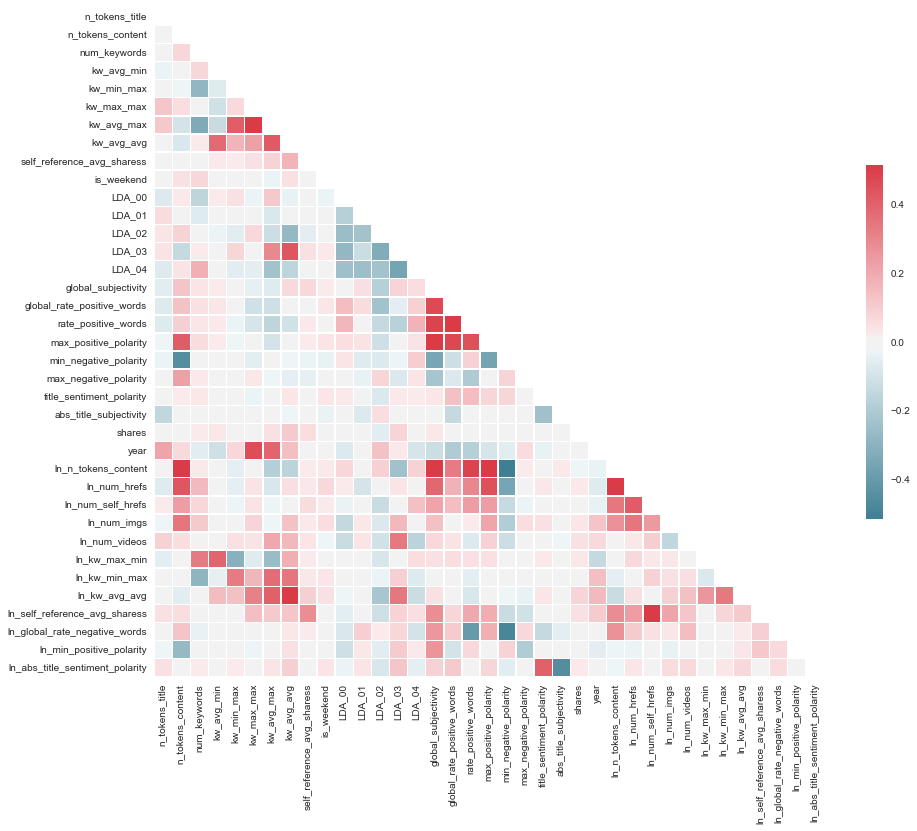

In [40]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# from example found at https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/notebook

In [41]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Popularity Variable . Article is considerd popular if it has more than 1400 shares. 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

popular_binary = np.where(df['shares'] > 1400, True, False)

df.insert(loc = 0, column = 'popular', value = popular_binary)

del df['shares'] 

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 39 columns):
popular                            39644 non-null bool
n_tokens_title                     39644 non-null int64
n_tokens_content                   39644 non-null int64
num_keywords                       39644 non-null int64
kw_avg_min                         39644 non-null float64
kw_min_max                         39644 non-null float64
kw_max_max                         39644 non-null float64
kw_avg_max                         39644 non-null float64
kw_avg_avg                         39644 non-null float64
self_reference_avg_sharess         39644 non-null float64
is_weekend                         39644 non-null float64
LDA_00                             39644 non-null float64
LDA_01                             39644 non-null float64
LDA_02                             39644 non-null float64
LDA_03                             39644 non-null float64
LDA_04                        

### One-hot encoding of categorical variables

In [42]:
# ...  day of week categorical variable

tmp_df = pd.get_dummies(df.day_of_week, prefix = 'day_of_week')
df = pd.concat((df, tmp_df), axis = 1) # add back into the dataframe

if 'day_of_week' in df:
    del df['day_of_week'] 

# ...  data channel categorical variable

tmp_df = pd.get_dummies(df.data_channel, prefix = 'data_channel')
df = pd.concat((df, tmp_df), axis = 1) # add back into the dataframe

if 'data_channel' in df:
    del df['data_channel'] 

#df.info()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  this basically just undoes what we did above to combine these into single variable
# ...  - but allowed us to demonstrate use of get_dummies function
# ...  - and, these are nicer data variable names (;-)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [43]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  branch a separate copy of data frame to support SVM development
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_svm = df.copy()


data_dir = '../data/'
data_file = 'mashable_clean_dataset_4_svm.csv'

file_2_write = data_dir + data_file

df_svm.to_csv(file_2_write, index = False)

df_svm.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 50 columns):
popular                            39644 non-null bool
n_tokens_title                     39644 non-null int64
n_tokens_content                   39644 non-null int64
num_keywords                       39644 non-null int64
kw_avg_min                         39644 non-null float64
kw_min_max                         39644 non-null float64
kw_max_max                         39644 non-null float64
kw_avg_max                         39644 non-null float64
kw_avg_avg                         39644 non-null float64
self_reference_avg_sharess         39644 non-null float64
is_weekend                         39644 non-null float64
LDA_00                             39644 non-null float64
LDA_01                             39644 non-null float64
LDA_02                             39644 non-null float64
LDA_03                             39644 non-null float64
LDA_04                        

## Training and Testing Split


For training and testing purposes, we use 80% of the observations for training and 20% for testing. This process is repeated three times and use the hold out cross validation method built into scikit-learn.

In [44]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from sklearn.svm import SVC

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'popular' in df_svm:
    y = df_svm['popular'].values         # set 'popular' as dependent
    del df_svm['popular']                # remove from dataset
    X = df_svm.values                    # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup cross-validation in sklearn
# ...
# ...  split into training and test sets
# ....  --> 3 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 3

num_instances = len(y)

cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)



***  

# __Support Vector Machine__  

*** 



In [45]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  run through the cross validation loop and set the training and testing
# ...  variable for one single iteration
# ...
# ...  --> this method is memory-user, but easier to follow what is being done 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for train_indices, test_indices in cv_object.split(X, y): 
    X_train = X[train_indices]
    y_train = y[train_indices]    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... scale attributes by the training set
# ... - normalize features based on mean & stdev of each column
# ... - do not use the testing data - this would be snooping
# ... - use what was last stored in the variables: X_train, y_train, X_test, y_test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

scl_obj = StandardScaler()
scl_obj.fit(X_train)                        # scale for each column for (0,1) mean, std
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 



In [46]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... use SVM, train the model
# ...
# ... - C = 0.5
# ...   - penalty parameter; controls the trade-off between smooth decision boundary
# ...   - and classifying the training points correctly
# ...
# ... - kernel = linear
# ...
# ... - gamma = auto
# ...   - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’;
# ...   - the higher the value of gamma, will try to exact fit
# ...   - for the rbf kernel the transformed space is infinite-dimensional
# ...
# ...  https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

tic = time.clock()

# ...  get SVC object

svm_clf = SVC(C = 0.5, kernel = 'linear', degree = 3, gamma = 'auto')

# ... train

svm_clf.fit(X_train_scaled, y_train)

# ... print out process time

toc = time.clock()
print('\n----------------------------------------------------')
print('Process time : ', toc - tic, 'seconds')
print('----------------------------------------------------')

# ... test set predictions

y_hat = svm_clf.predict(X_test_scaled)

# ... model classification metrics

acc = mt.accuracy_score(y_test, y_hat)
rec = mt.recall_score(y_test, y_hat)
pre = mt.precision_score(y_test, y_hat)

f1s = mt.f1_score(y_test, y_hat)

conf = mt.confusion_matrix(y_test, y_hat)

print('\n----------------------------------------------------')
print('Model Accuracy = ', acc )
print('Model Recall = ', rec )
print('Model Precision = ', pre )
print('Model F1 Score = ', f1s )

print('\n----------------------------------------------------')
print('Confusion matrix\n', conf)
print('----------------------------------------------------')



----------------------------------------------------
Process time :  269.87051999999994 seconds
----------------------------------------------------

----------------------------------------------------
Model Accuracy =  0.640055492496
Model Recall =  0.629374201788
Model Precision =  0.637186449444
Model F1 Score =  0.633256232331

----------------------------------------------------
Confusion matrix
 [[2611 1403]
 [1451 2464]]
----------------------------------------------------


In [47]:
# look at the support vectors

print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(24636, 49)
(24636,)
[12316 12320]


[[ -5.77184217e-03   1.55213092e-01   3.70703672e-02  -1.38763796e-01
   -1.58373905e-02  -1.53863174e-01  -5.71391891e-02   4.20459008e-01
    5.49116355e-02   1.11096031e-01  -1.70329896e-01  -3.57161212e-01
   -4.60504617e-01  -4.80820330e-01  -3.62457248e-01   9.15085750e-02
   -7.03074638e-03  -5.76801513e-03   4.34941968e-05   5.39183159e-03
    1.24782274e-02   4.61070076e-02   3.13309798e-02   2.70935537e-02
   -1.74790095e-01   8.96226061e-02  -1.34905767e-01   3.40235242e-02
    5.86284983e-02   2.89891739e-02  -7.63106708e-02   9.60012729e-02
    1.43121752e-01  -1.41829272e-02  -5.78362646e-02   9.51941613e-03
    2.13508026e-02  -1.31736203e-03   9.15492605e-02   6.09360978e-02
   -3.33015790e-02  -3.34077355e-02  -4.75686273e-02  -3.48826809e-01
   -3.90315063e-01  -6.29398487e-02   1.00803814e-01   1.72033823e-01
   -3.31275743e-01]]
49
Index(['n_tokens_title', 'n_tokens_content', 'num_keywords', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_avg_avg'

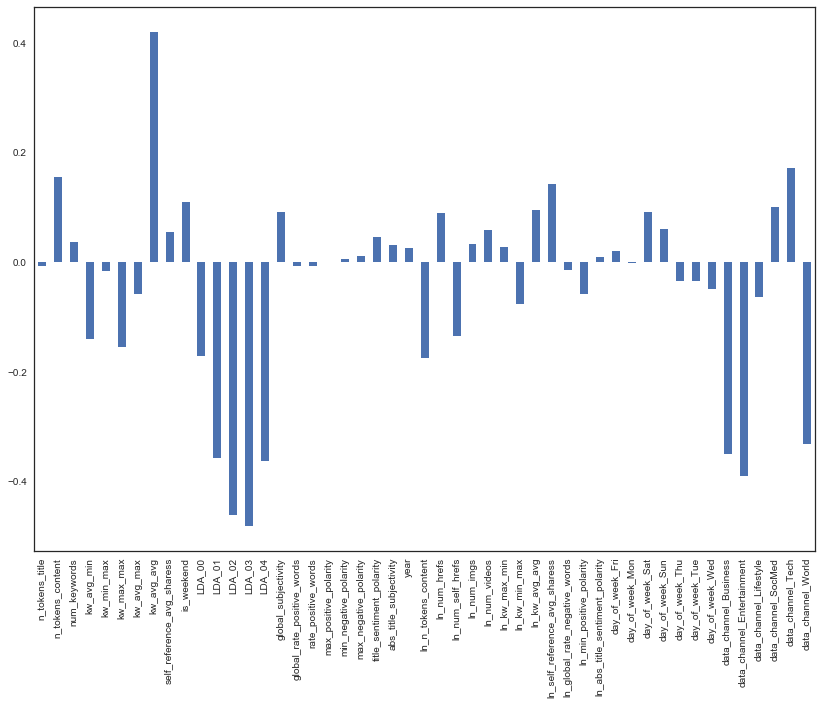

In [48]:
# Yes, there is attribute coef_ for SVM classifier but it only works for SVM with linear kernel. For other kernels it is not possible because data are transformed by kernel method to another space, which is not related to input space, check the explanation.

# if using linear kernel, these make sense to look at (not otherwise, why?)

print(svm_clf.coef_)
print(len(svm_clf.coef_[0]))

weights = pd.Series(svm_clf.coef_[0], index = df_svm.columns)
plt.figure(figsize=(14,10))
weights.plot(kind = 'bar')

print(df_svm.columns)
print(len(df_svm.columns))


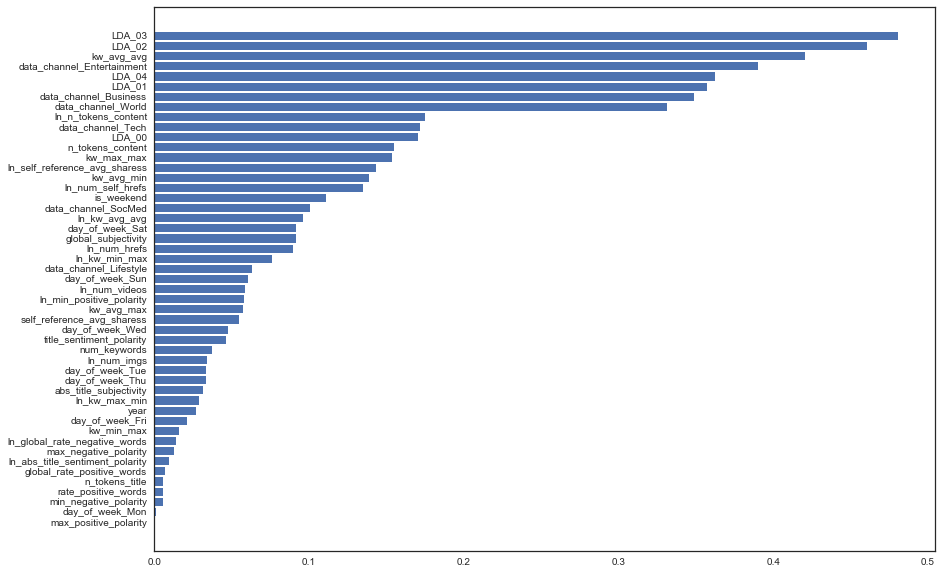

max_positive_polarity
day_of_week_Mon
min_negative_polarity
rate_positive_words
n_tokens_title
global_rate_positive_words
ln_abs_title_sentiment_polarity
max_negative_polarity
ln_global_rate_negative_words
kw_min_max
day_of_week_Fri
year
ln_kw_max_min
abs_title_subjectivity
day_of_week_Thu
day_of_week_Tue
ln_num_imgs
num_keywords
title_sentiment_polarity
day_of_week_Wed
self_reference_avg_sharess
kw_avg_max
ln_min_positive_polarity
ln_num_videos
day_of_week_Sun
data_channel_Lifestyle
ln_kw_min_max
ln_num_hrefs
global_subjectivity
day_of_week_Sat
ln_kw_avg_avg
data_channel_SocMed
is_weekend
ln_num_self_hrefs
kw_avg_min
ln_self_reference_avg_sharess
kw_max_max
n_tokens_content
LDA_00
data_channel_Tech
ln_n_tokens_content
data_channel_World
data_channel_Business
LDA_01
LDA_04
data_channel_Entertainment
kw_avg_avg
LDA_02
LDA_03


In [49]:
# ... https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

def f_importances(coef, names):
    imp = coef
    imp_abs = abs(coef)
    imp, names = zip(*sorted(zip(imp_abs, names)))
    plt.figure(figsize=(14,10))
    plt.barh(range(len(names)), imp, align = 'center')
    plt.yticks(range(len(names)), names)
    plt.show()
    print("\n".join(names))

f_importances(svm_clf.coef_[0], df_svm.columns)

In [50]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data

df_tested_on = df_svm.iloc[train_indices] # saved from above, the indices chosen for training

# now get the support vectors from the trained model

df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['popular'] = y[svm_clf.support_] # add back in the 'popular' Column to the pandas dataframe
df_svm['popular'] = y # also add it back in for the original data

df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24636 entries, 4015 to 39136
Data columns (total 50 columns):
n_tokens_title                     24636 non-null int64
n_tokens_content                   24636 non-null int64
num_keywords                       24636 non-null int64
kw_avg_min                         24636 non-null float64
kw_min_max                         24636 non-null float64
kw_max_max                         24636 non-null float64
kw_avg_max                         24636 non-null float64
kw_avg_avg                         24636 non-null float64
self_reference_avg_sharess         24636 non-null float64
is_weekend                         24636 non-null float64
LDA_00                             24636 non-null float64
LDA_01                             24636 non-null float64
LDA_02                             24636 non-null float64
LDA_03                             24636 non-null float64
LDA_04                             24636 non-null float64
global_subjectivity     

/home/mcdevitt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


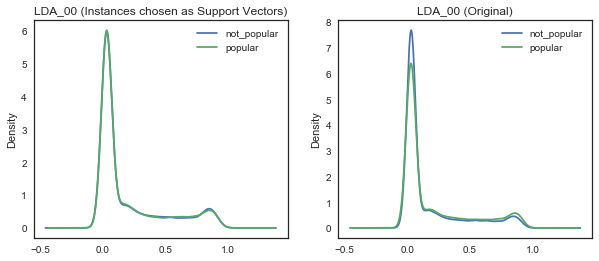

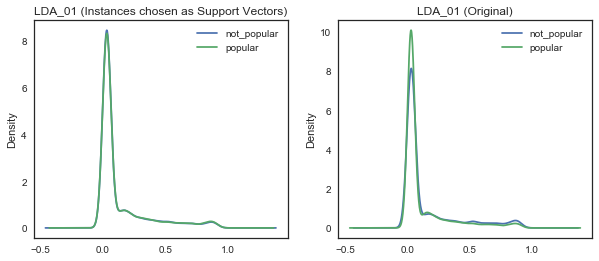

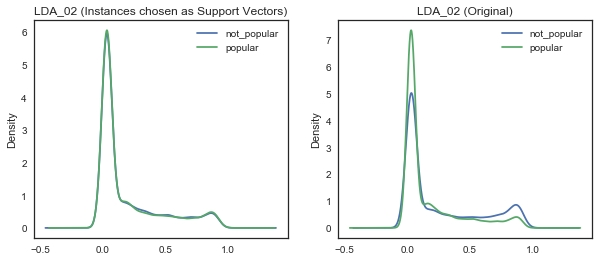

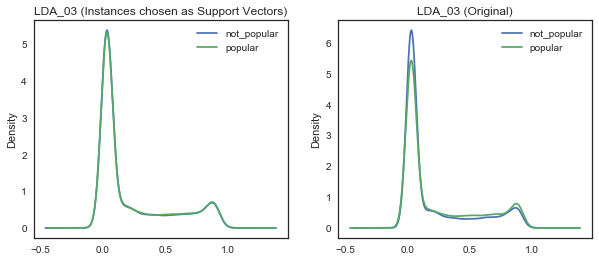

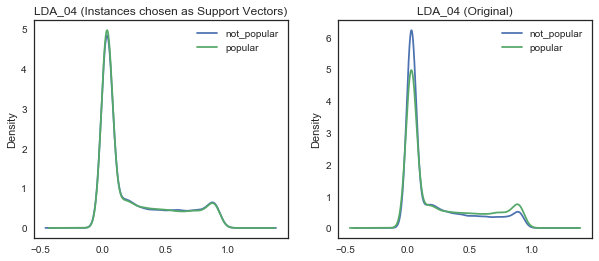

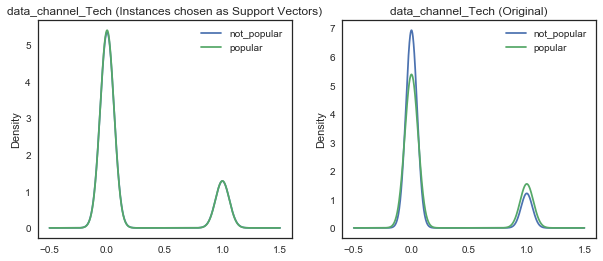

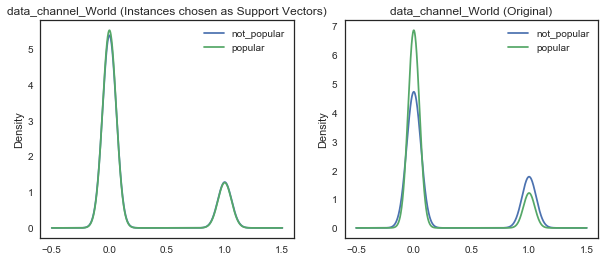

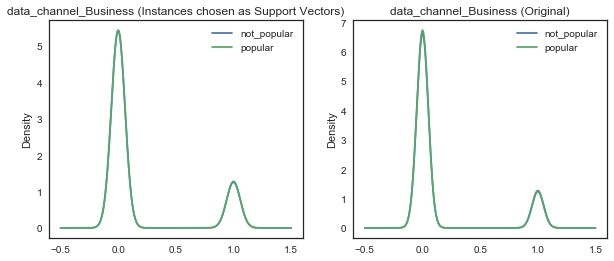

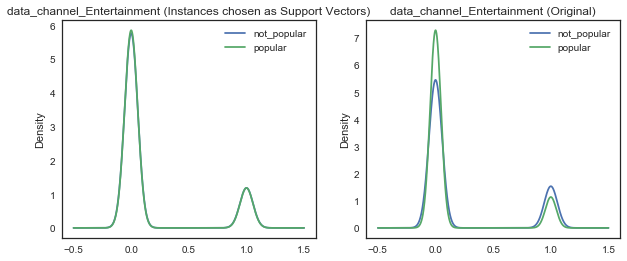

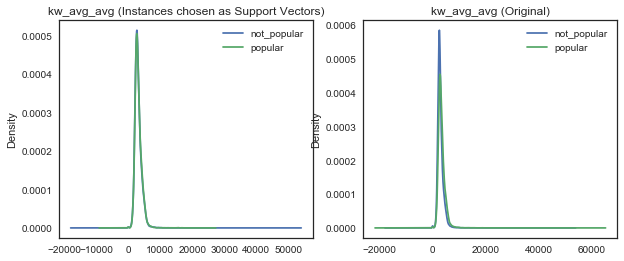

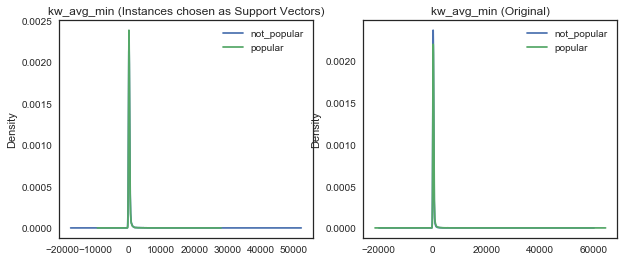

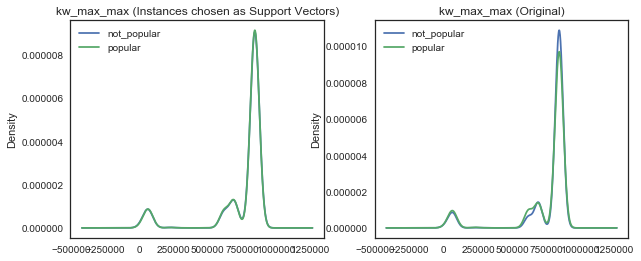

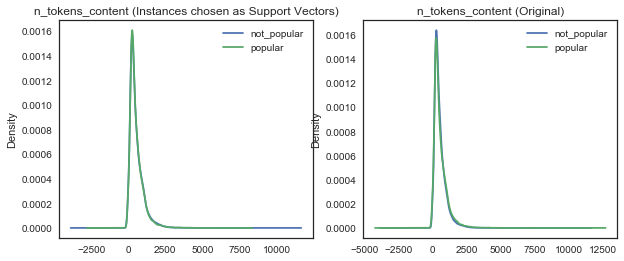

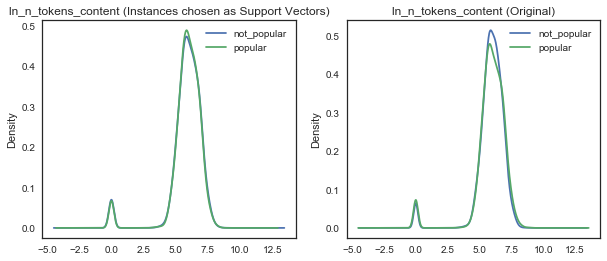

In [51]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors

df_grouped_support = df_support.groupby(['popular'])
df_grouped = df_svm.groupby(['popular'])

# plot KDE of Different variables

vars_to_plot = ['LDA_00',
    'LDA_01',
    'LDA_02',
    'LDA_03',
    'LDA_04',
    'data_channel_Tech',
    'data_channel_World',
    'data_channel_Business',
    'data_channel_Entertainment',
    'kw_avg_avg',
    'kw_avg_min',
    'kw_max_max',
    'n_tokens_content',
    'ln_n_tokens_content']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['not_popular','popular'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['not_popular','popular'])
    plt.title(v+' (Original)')



So the analysis here is basically telling us what the original statistics of the data looked like, and also what the statistics of the support vectors looked like. We can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.
  
You can also look at joint plots of the data and see how relationships have changed. (Hint hint for the min-lab assignment--this would be a nice analysis of the support vectors.)  

That's mostly it for using these things! They are really nice analysis tools and provide human interpretable summaries of the data.   

### SVM - Version 2


In [52]:

# ... select top17 weighted parameters from linear model
# ... use in non-linear kernal analyses for ?improved? accuracy
# ... first : repeat linear analysis to see if accuracy affected by down-select

cols_2_keep = [
 'is_weekend',
 'ln_num_self_hrefs',
 'n_tokens_content',
 'ln_self_reference_avg_sharess',
 'LDA_00',
 'kw_max_max',
 'kw_avg_min',
 'ln_n_tokens_content',
 'data_channel_Tech',
 'data_channel_World',
 'LDA_01',
 'data_channel_Business',
 'LDA_04',
 'data_channel_Entertainment',
 'kw_avg_avg',
 'LDA_02',
 'LDA_03']

df_svm = df_svm[cols_2_keep]



In [53]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'popular' in df_svm:
    y = df_svm['popular'].values         # set 'popular' as dependent
    del df_svm['popular']                # remove from dataset
    X = df_svm.values                    # use everything else for independent EVs

    

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup cross-validation in sklearn
# ...
# ...  split into training and test sets
# ....  --> 3 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 3

num_instances = len(y)

cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [54]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  run through the cross validation loop and set the training and testing
# ...  variable for one single iteration
# ...
# ...  --> this method is memory-user, but easier to follow what is being done 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for train_indices, test_indices in cv_object.split(X, y): 
    X_train = X[train_indices]
    y_train = y[train_indices]    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... scale attributes by the training set
# ... - normalize features based on mean & stdev of each column
# ... - do not use the testing data - this would be snooping
# ... - use what was last stored in the variables: X_train, y_train, X_test, y_test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

scl_obj = StandardScaler()
scl_obj.fit(X_train)                        # scale for each column for (0,1) mean, std
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 



In [55]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... use SVM, train the model
# ...
# ... - C = 0.5
# ...   - penalty parameter; controls the trade-off between smooth decision boundary
# ...   - and classifying the training points correctly
# ...
# ... - kernel = linear
# ...
# ... - gamma = auto
# ...   - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’;
# ...   - the higher the value of gamma, will try to exact fit
# ...   - for the rbf kernel the transformed space is infinite-dimensional
# ...
# ...  https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

tic = time.clock()

# ...  get SVC object

svm_clf = SVC(C = 0.5, kernel = 'linear', degree = 3, gamma = 'auto')

# ... train

svm_clf.fit(X_train_scaled, y_train)

# ... print out process time

toc = time.clock()
print('\n----------------------------------------------------')
print('Process time : ', toc - tic, 'seconds')
print('----------------------------------------------------')

# ... test set predictions

y_hat = svm_clf.predict(X_test_scaled)

# ... model classification metrics

acc = mt.accuracy_score(y_test, y_hat)
rec = mt.recall_score(y_test, y_hat)
pre = mt.precision_score(y_test, y_hat)

f1s = mt.f1_score(y_test, y_hat)

conf = mt.confusion_matrix(y_test, y_hat)

print('\n----------------------------------------------------')
print('Model Accuracy = ', acc )
print('Model Recall = ', rec )
print('Model Precision = ', pre )
print('Model F1 Score = ', f1s )

print('\n----------------------------------------------------')
print('Confusion matrix\n', conf)
print('----------------------------------------------------')



----------------------------------------------------
Process time :  266.86367799999994 seconds
----------------------------------------------------

----------------------------------------------------
Model Accuracy =  0.635893555303
Model Recall =  0.614739517154
Model Precision =  0.638258575198
Model F1 Score =  0.626278317152

----------------------------------------------------
Confusion matrix
 [[2623 1371]
 [1516 2419]]
----------------------------------------------------


In [56]:
df_svm.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 17 columns):
is_weekend                       39644 non-null float64
ln_num_self_hrefs                39644 non-null float64
n_tokens_content                 39644 non-null int64
ln_self_reference_avg_sharess    39644 non-null float64
LDA_00                           39644 non-null float64
kw_max_max                       39644 non-null float64
kw_avg_min                       39644 non-null float64
ln_n_tokens_content              39644 non-null float64
data_channel_Tech                39644 non-null uint8
data_channel_World               39644 non-null uint8
LDA_01                           39644 non-null float64
data_channel_Business            39644 non-null uint8
LDA_04                           39644 non-null float64
data_channel_Entertainment       39644 non-null uint8
kw_avg_avg                       39644 non-null float64
LDA_02                           39644 non-null float64
LDA_0

#### Same accuracy with 17 down selected features as above with 49 features  

Re-run analysis with 17 features and non-linear kernel  
kernel = __rbf__  


In [57]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... use SVM, train the model
# ...
# ... - C = 0.5
# ...   - penalty parameter; controls the trade-off between smooth decision boundary
# ...   - and classifying the training points correctly
# ...
# ... - kernel = rbf
# ...
# ... - gamma = auto
# ...   - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’;
# ...   - the higher the value of gamma, will try to exact fit
# ...   - for the rbf kernel the transformed space is infinite-dimensional
# ...
# ...  https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

tic = time.clock()

# ...  get SVC object

svm_clf = SVC(C = 0.5, kernel = 'rbf', degree = 3, gamma = 'auto')

# ... train

svm_clf.fit(X_train_scaled, y_train)

# ... print out process time

toc = time.clock()
print('\n----------------------------------------------------')
print('Process time : ', toc - tic, 'seconds')
print('----------------------------------------------------')

# ... test set predictions

y_hat = svm_clf.predict(X_test_scaled)

# ... model classification metrics

acc = mt.accuracy_score(y_test, y_hat)
rec = mt.recall_score(y_test, y_hat)
pre = mt.precision_score(y_test, y_hat)
f1s = mt.f1_score(y_test, y_hat)

conf = mt.confusion_matrix(y_test, y_hat)

print('\n----------------------------------------------------')
print('Model Accuracy = ', acc )
print('Model Recall = ', rec )
print('Model Precision = ', pre )
print('Model F1 Score = ', f1s )

print('\n----------------------------------------------------')
print('Confusion matrix\n', conf)
print('----------------------------------------------------')



----------------------------------------------------
Process time :  138.09346499999992 seconds
----------------------------------------------------

----------------------------------------------------
Model Accuracy =  0.655568167486
Model Recall =  0.632274459975
Model Precision =  0.659597030753
Model F1 Score =  0.645646814584

----------------------------------------------------
Confusion matrix
 [[2710 1284]
 [1447 2488]]
----------------------------------------------------


### Read in "imp_features" from EDA analysis for comparison

In [58]:
data_dir = '../data/'
data_file = 'mashable_imp_features_from_eda.csv'

file_2_read = data_dir + data_file

df_imp = pd.read_csv(file_2_read)  

In [29]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'popular' in df_imp:
    y = df_imp['popular'].values         # set 'popular' as dependent
    del df_imp['popular']                # remove from dataset
    X = df_imp.values                    # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup cross-validation in sklearn
# ...
# ...  split into training and test sets
# ....  --> 3 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 3

num_instances = len(y)

cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [ ]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  run through the cross validation loop and set the training and testing
# ...  variable for one single iteration
# ...
# ...  --> this method is memory-user, but easier to follow what is being done 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for train_indices, test_indices in cv_object.split(X, y): 
    X_train = X[train_indices]
    y_train = y[train_indices]    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... scale attributes by the training set
# ... - normalize features based on mean & stdev of each column
# ... - do not use the testing data - this would be snooping
# ... - use what was last stored in the variables: X_train, y_train, X_test, y_test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    scl_obj = StandardScaler()
    scl_obj.fit(X_train)                        # scale for each column for (0,1) mean, std
    
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... use SVM, train the model
# ...
# ... - C = 0.5
# ...   - penalty parameter; controls the trade-off between smooth decision boundary
# ...   - and classifying the training points correctly
# ...
# ... - kernel = linear
# ...
# ... - gamma = auto
# ...   - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’;
# ...   - the higher the value of gamma, will try to exact fit
# ...   - for the rbf kernel the transformed space is infinite-dimensional
# ...
# ...  https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    tic = time.clock()

# ...  get SVC object

    svm_clf = SVC(C = 0.5, kernel = 'linear', degree = 3, gamma = 'auto')

# ... train

    svm_clf.fit(X_train_scaled, y_train)

# ... print out process time

    toc = time.clock()
    print('\n----------------------------------------------------')
    print('Process time : ', toc - tic, 'seconds')
    print('----------------------------------------------------')

# ... test set predictions

    y_hat = svm_clf.predict(X_test_scaled)

# ... model classification metrics

    acc = mt.accuracy_score(y_test, y_hat)
    rec = mt.recall_score(y_test, y_hat)
    pre = mt.precision_score(y_test, y_hat)
    f1s = mt.f1_score(y_test, y_hat)
    conf = mt.confusion_matrix(y_test, y_hat)

    print('\n----------------------------------------------------')
    print('Model Accuracy = ', acc )
    print('Model Recall = ', rec )
    print('Model Precision = ', pre )
    print('Model F1 Score = ', f1s )

    print('\n----------------------------------------------------')
    print('Confusion matrix\n', conf)
    print('----------------------------------------------------')